# Cryptocurrency Price Prediction with Deep Learning

## Overview

In this final project, I have chosen the problem of predicting future cryptocurrency prices using historical price and volume data. The specific coin used here is **Ethereum (ETH)**. The goal is to forecast the next 5 days of prices based on the last 100 days of historical data.

### Problem to Solve

Cryptocurrency markets are highly volatile, and traders/investors want to predict future prices to make informed decisions. While perfect predictions are impossible, building a deep learning model to analyze historical price patterns may provide insights into future movements.

### ML Approach / Methods Used

I will use a Recurrent Neural Network (RNN) approach with an LSTM (Long Short-Term Memory) model. The pipeline includes:

1. **Data collection and cleaning**
2. **Exploratory Data Analysis (EDA)**
   - Data Loading and Initial Inspection
   - Data Quality Assessment
   - Basic Statistical Analysis
   - Price Movement Analysis
   - Volume Analysis
   - Correlation Studies
3. **Feature engineering**
   - Technical Indicators Calculation (RSI, MACD, Bollinger Bands, etc.)
   - Feature Visualization
   - Feature Importance Analysis (if applicable)
   - Feature Selection
4. **Data splitting and scaling**
5. **Model architecture and training**
   - Architecture defined in `config.yaml`
6. **Model evaluation**
   - Training history visualization (losses, metrics)
   - Actual vs Predicted Prices on test data
7. **Future predictions (5-day forecast)**

We will rely on the scripts developed in `src/` for the pipeline and model operations. We also have `visualizer_notebook.py` in `src/visualization/` for generating plots within the notebook.

## Project Setup

Directory structure and files:
- `data/raw/train/`: Contains historical training data CSV files (e.g., `ethereum_binance_20241210.csv`)
- `data/raw/predict/`: Contains recent data for prediction (e.g., `ethereum_binance_recent_20241210.csv`)
- `src/`: Contains pipeline, model, and utility scripts
- `src/visualization/visualizer_notebook.py`: A visualizer module adapted for Jupyter
- `models/ethereum/model.keras`: A trained model (assumed pre-trained)
- `results/`: Contains result JSON files (e.g., training history, predictions)
- `configs/config.yaml`: Configuration file

## Next Steps in Notebook

We will:
1. Load configuration and data.
2. Perform EDA.
3. Run pipeline (feature engineering, scaling).
4. Show model architecture details from `config.yaml`.
5. Visualize training history from a results JSON file.
6. Evaluate the model on test data and show predictions vs actual.
7. Make future predictions and visualize them.

In [1]:
# Imports and Setup

import sys
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
!pwd
sys.path.append('/notebooks/Deep-Learning-Crypto/src')
project_root = os.path.abspath("..")  # move one directory up from notebooks
src_path = os.path.join(project_root, "src")
sys.path.append(src_path)
from src.preprocessing.pipeline import Pipeline

from src.preprocessing.pipeline import Pipeline
from src.training.model import CryptoPredictor
from src.utils.config import Config
from src.visualization.visualizer_notebook import NotebookVisualizer

# Setup logging for the notebook
logging.basicConfig(level=logging.INFO, format='%(message)s')

# Load configuration
config = Config("configs/config.yaml")

# Initialize our visualizer
viz = NotebookVisualizer()

# Set a consistent style for plots
plt.style.use('seaborn')

/notebooks/Deep-Learning-Crypto


2024-12-10 20:31:02.798653: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-10 20:31:04.611457: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-10 20:31:06.145156: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-10 20:31:06.193005: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

## EDA: Data Loading and Initial Inspection

We assume the training data for Ethereum is located at `data/raw/train/ethereum_binance_20241210.csv`. Let's load and inspect it.


In [2]:
# Load Training Data
train_data_path = os.path.join(config.get_path('raw_data_dir'), "ethereum_binance_20241210.csv")
df = pd.read_csv(train_data_path, index_col=0, parse_dates=True)

print("Data head:")
display(df.head())

print("Data info:")
df.info()

print("Data describe:")
display(df.describe())

Data head:


,open,high,low,close,volume
timestamp,,,,,
2022-03-17,2773.80,2836.00,2746.42,2811.92,379312.5410
2022-03-18,2811.91,2984.00,2765.59,2938.92,556535.7966
2022-03-19,2938.84,2987.70,2890.86,2950.84,325971.5398
2022-03-20,2950.85,2964.17,2817.21,2861.38,377608.8214
2022-03-21,2861.39,2960.57,2829.81,2890.03,450223.9073


Data info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2022-03-17 to 2024-12-10
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1000 non-null   float64
 1   high    1000 non-null   float64
 2   low     1000 non-null   float64
 3   close   1000 non-null   float64
 4   volume  1000 non-null   float64
dtypes: float64(5)
memory usage: 46.9 KB
Data describe:


,open,high,low,close,volume
count,1000.00000,1000.000000,1000.000000,1000.000000,1.000000e+03
mean,2201.22512,2254.049570,2146.248570,2202.155840,4.966868e+05
std,761.90886,780.217255,741.723919,763.176007,3.773738e+05
min,995.12000,1078.880000,881.560000,995.130000,5.851962e+04
25%,1629.10000,1657.395000,1589.222500,1629.095000,2.554311e+05
50%,1905.90500,1942.740000,1872.410000,1905.900000,3.974495e+05
75%,2789.89250,2863.015000,2734.907500,2803.767500,5.976551e+05
max,4064.80000,4093.920000,3968.000000,4064.800000,3.626352e+06


### Data Quality Assessment

Check for missing values and basic sanity checks.


In [ ]:
# Data Quality Checks
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 open      0
high      0
low       0
close     0
volume    0
dtype: int64


### Price Movement Analysis

We've plotted the price and volume. We can also look at daily returns to understand volatility.


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


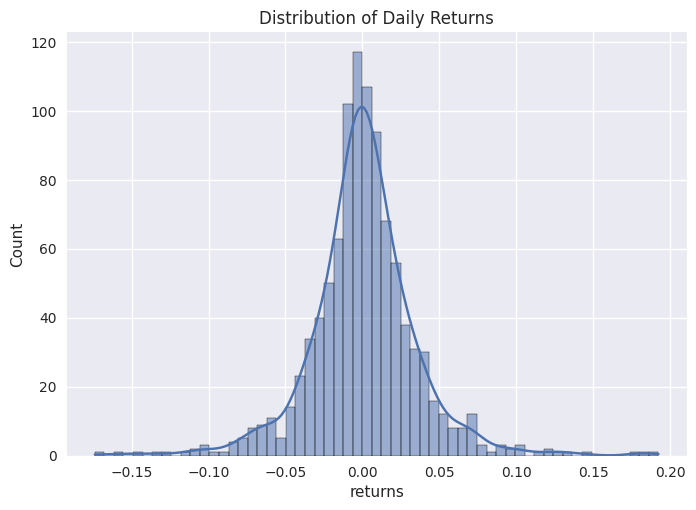

In [4]:
# Returns Analysis
df['returns'] = df['close'].pct_change()
sns.histplot(df['returns'].dropna(), kde=True)
plt.title("Distribution of Daily Returns")
plt.show()


### Volume Analysis

Let's look at volume over time. This helps us see how trading activity changes.


Volume stats:


count    1.000000e+03
mean     4.966868e+05
std      3.773738e+05
min      5.851962e+04
25%      2.554311e+05
50%      3.974495e+05
75%      5.976551e+05
max      3.626352e+06
Name: volume, dtype: float64

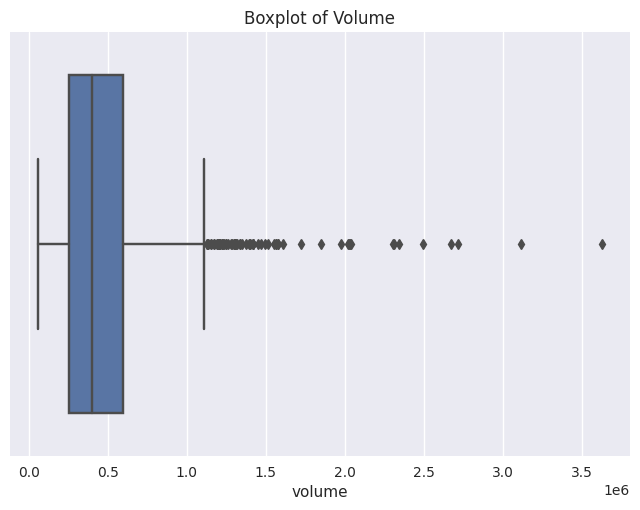

In [ ]:
# Volume Statistics
print("Volume stats:")
display(df['volume'].describe())

sns.boxplot(x=df['volume'])
plt.title("Boxplot of Volume")
plt.show()


## Boxplot Findings:

- A relatively high concentration of data at lower volume values, with a median at around 0.5 million.
- A number of outliers extending far to the right, indicating that, on some days, trading volume was significantly higher than on a typical day.
### This suggests that while most trading volumes cluster within a moderate range, there can be occasional spikes in volume, possibly due to market news, events, or heightened investor interest on specific days.

### Correlation Studies

We can examine the correlation matrix of numerical features to see relationships.


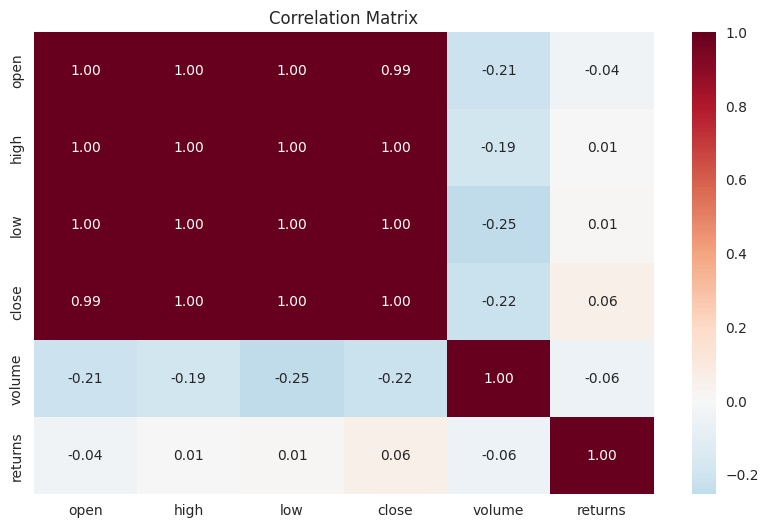

In [ ]:
# Correlation Matrix
viz.plot_correlation_matrix(df)


## Matrix Findings:

- The price-related features (open, high, low, close) are all highly correlated with each other, which is expected since they represent prices of the same asset over similar time frames.
- Volume shows a modest negative correlation with prices, suggesting that higher trading volumes don't necessarily coincide with higher (or lower) prices in a straightforward manner.
- Returns (a calculated feature, typically daily returns) show weak correlations with both price and volume, indicating that short-term returns may not be strongly predicted by just the raw price levels or volume data.
### Overall, this correlation matrix highlights the strong interrelationships among price-based features and the relatively independent behavior of volume and returns.

## Feature Engineering

We will use the pipeline which includes the feature engineering module. It adds technical indicators such as RSI, MACD, Bollinger Bands, etc.

### Setup and Data Loading

We have our `df` loaded. Let's run the pipeline in training mode to see what features it creates.


In [3]:
# Pipeline and Feature Engineering
pipeline = Pipeline(config=config)

# Run pipeline in training mode
train_result = pipeline.run(df, save_dir=None, prediction_mode=False)

X_train = train_result['X_train']
y_train = train_result['y_train']
X_val = train_result['X_val']
y_val = train_result['y_val']
X_test = train_result['X_test']
y_test = train_result['y_test']

print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)
print("Test data shape:", X_test.shape, y_test.shape)

print("Numeric features used:", train_result['numeric_features'])


2024-12-10 20:31:14,472 - src.preprocessing.pipeline - INFO - Pipeline initialized with sequence_length=50, prediction_length=1, test_size=0.1, validation_size=0.1, feature_scaler_type=standard, target_scaler_type=robust
Pipeline initialized with sequence_length=50, prediction_length=1, test_size=0.1, validation_size=0.1, feature_scaler_type=standard, target_scaler_type=robust
2024-12-10 20:31:14,478 - src.preprocessing.pipeline - INFO - Applying feature engineering...
Applying feature engineering...
2024-12-10 20:31:14,501 - src.preprocessing.feature_engineering - WARNING - Missing values detected, applying bfill and ffill.
Missing values detected, applying bfill and ffill.
2024-12-10 20:31:14,506 - src.preprocessing.feature_engineering - INFO - All features updated, total columns: 12
All features updated, total columns: 12
2024-12-10 20:31:14,508 - src.preprocessing.feature_engineering - INFO - Added 7 technical features.
Added 7 technical features.
2024-12-10 20:31:14,512 - src.prep

Training data shape: (850, 50, 12) (850, 2)
Validation data shape: (250, 50, 12) (250, 2)
Test data shape: (150, 50, 12) (150, 2)
Numeric features used: ['open', 'high', 'low', 'volume', 'rsi', 'macd', 'macd_signal', 'macd_hist', 'bb_upper', 'bb_middle', 'bb_lower']


### Technical Indicators Calculation

The pipeline (via `FeatureEngineer`) has added technical indicators. We can inspect a sample of the processed DataFrame before splitting to see the added features.


2024-12-10 20:28:02,939 - src.preprocessing.pipeline - INFO - Applying feature engineering...
Applying feature engineering...
2024-12-10 20:28:02,959 - src.preprocessing.feature_engineering - WARNING - Missing values detected, applying bfill and ffill.
Missing values detected, applying bfill and ffill.
2024-12-10 20:28:02,963 - src.preprocessing.feature_engineering - INFO - All features updated, total columns: 13
All features updated, total columns: 13
2024-12-10 20:28:02,965 - src.preprocessing.feature_engineering - INFO - Added 8 technical features.
Added 8 technical features.


Features after technical indicator addition:


,open,high,low,close,volume,returns,rsi,macd,macd_signal,macd_hist,bb_upper,bb_middle,bb_lower
timestamp,,,,,,,,,,,,,
2024-12-06,3785.21,4087.73,3777.26,3998.87,803855.1146,0.056449,79.127869,145.398419,129.362830,16.035588,3972.566242,3711.529,3450.491758
2024-12-07,3998.87,4024.46,3968.00,3996.22,283920.0200,-0.000663,74.826919,153.865107,137.530256,16.334851,4057.956325,3745.823,3433.689675
2024-12-08,3996.22,4015.58,3923.50,4004.15,251362.1685,0.001984,74.993257,153.901442,142.987318,10.914124,4114.924244,3788.359,3461.793756
2024-12-09,4004.15,4006.17,3509.00,3712.00,939642.2001,-0.072962,54.175597,105.906283,130.626973,-24.720690,4102.825637,3800.338,3497.850363
2024-12-10,3712.00,3780.76,3615.11,3705.01,442916.4403,-0.001883,55.661345,71.200214,110.818053,-39.617839,4102.767473,3800.479,3498.190527


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


New technical features: ['returns', 'rsi', 'macd', 'macd_signal', 'macd_hist', 'bb_upper', 'bb_middle', 'bb_lower']


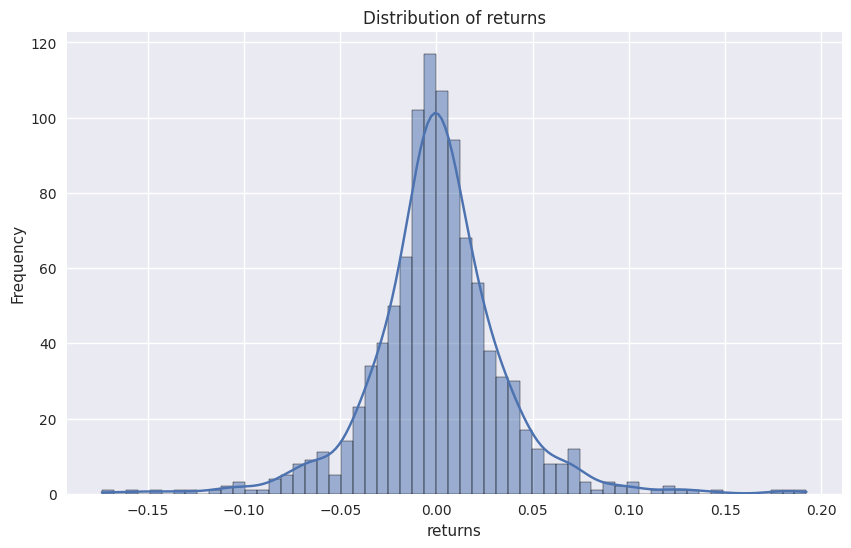

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


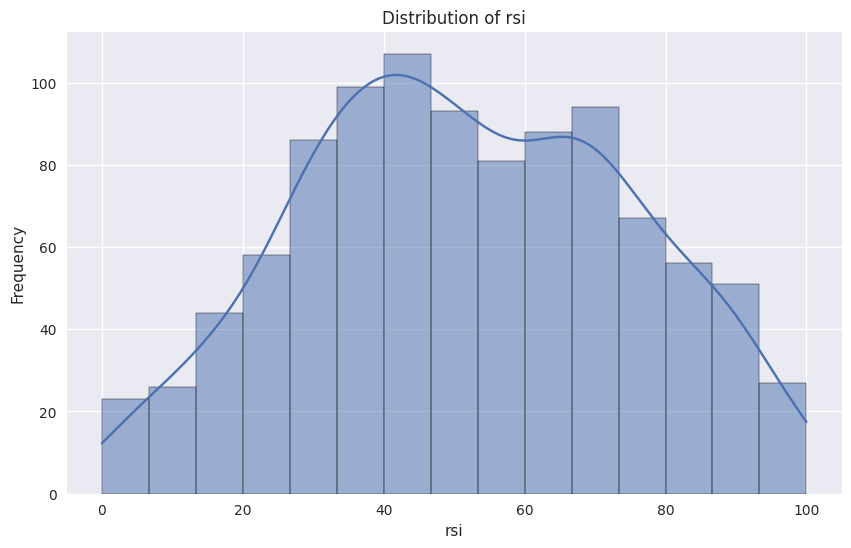

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


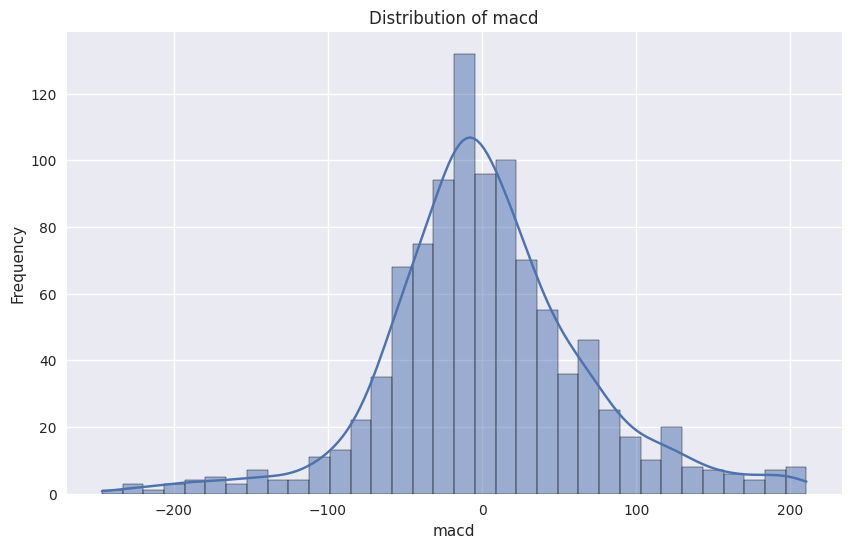

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


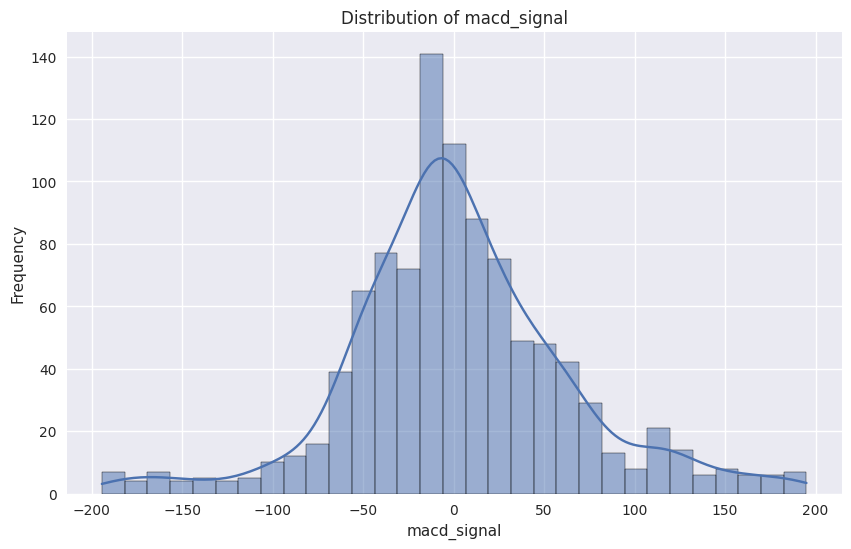

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


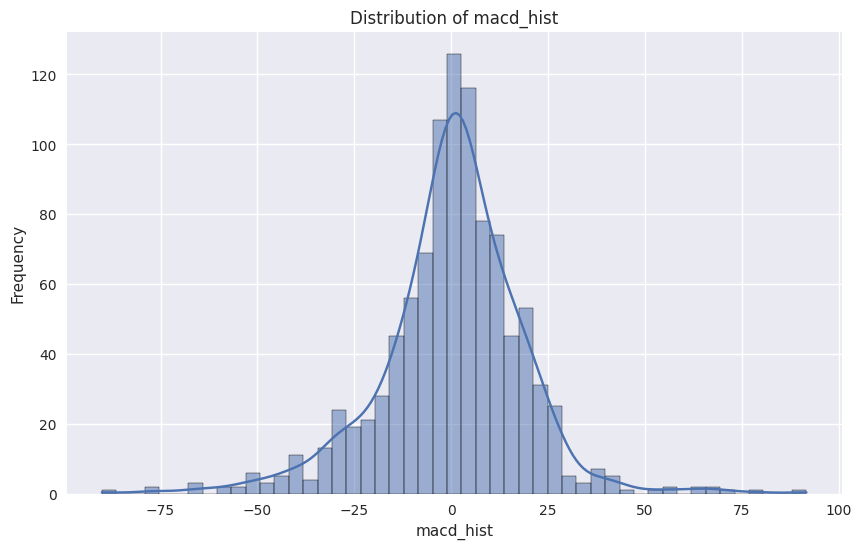

In [ ]:
# Inspect engineered features

df_features = pipeline.create_features(df.copy())

print("Features after technical indicator addition:")
display(df_features.tail())

# Visualize distributions of new features
new_feats = [c for c in df_features.columns if c not in ['open','high','low','close','volume']]
print("New technical features:", new_feats)
viz.plot_feature_distribution(df_features, columns=new_feats[:5], title_prefix="Distribution of")


**Distribution of Daily Returns Explanation:**

This histogram displays the frequency of daily returns (percentage change from one day’s closing price to the next). We observe the following characteristics:

- The distribution is roughly bell-shaped and centered near zero, suggesting that small daily changes (both positive and negative) are most common.
- The tails extend in both directions, but there are fewer large positive or negative returns. This indicates that while small gains and losses are frequent, large price swings are relatively rare.
- A near-symmetric distribution around zero implies that the market does not have a long-term bias in daily returns, at least in the short sample. Most days see modest gains or losses.

Overall, this distribution highlights a pattern of frequent small daily movements in price, with occasional but much less common large jumps, reflecting the volatile yet often mean-reverting nature of cryptocurrency markets.


**Distribution of RSI (Relative Strength Index) Explanation:**

The RSI is a momentum oscillator that measures the magnitude of recent price changes to evaluate overbought or oversold conditions. By examining its distribution:

- The histogram shows that RSI values are spread across the full 0 to 100 range, though they tend to cluster around the middle (roughly 30–70).
- High frequencies near the 40–60 range suggest that the market spends a lot of time in a neutral momentum state rather than consistently being in overbought (>70) or oversold (<30) territory.
- The relatively balanced shape, with a peak slightly above 40 and gradually tapering off toward both tails, indicates that extreme RSI conditions occur less frequently.

This distribution suggests that markets often hover around neutral momentum levels rather than persistently dwelling in extreme sentiment zones.


**Distribution of MACD Explanation:**

MACD (Moving Average Convergence Divergence) is derived from two moving averages of price and helps identify trend momentum and possible trend reversals. The distribution provides insights into MACD values over time:

- The histogram is approximately bell-shaped, centered near zero, indicating that the MACD line often oscillates around the equilibrium point.
- A concentration of values near zero suggests that the underlying market frequently experiences a balance between short-term and long-term momentum.
- Positive and negative extremes are less common, which implies that strongly trending conditions (persistently rising or falling markets) are present, but occur less frequently compared to more neutral states.

This distribution shows that while the market sometimes generates strong momentum signals, it commonly reverts back to a more balanced momentum environment around zero MACD.


**Distribution of MACD Signal Explanation:**

The MACD signal line is a moving average of the MACD itself, smoothing out short-term fluctuations. Examining its distribution:

- Like the MACD line, the signal’s distribution is roughly bell-shaped and centered near zero.
- The presence of a well-defined peak around zero indicates that the signal line also frequently returns to equilibrium, reinforcing the idea that strong momentum regimes are not the norm.
- Fewer occurrences of extreme positive or negative values suggest that sustained periods of strongly bullish or bearish signals (as indicated by the MACD line crossing above/below the signal) are relatively rare.

In essence, the MACD signal distribution confirms that large, persistent trend signals are not the majority scenario, aligning with the notion of price mean reversion and oscillation in markets.


**Distribution of MACD Histogram Explanation:**

The MACD histogram represents the difference between MACD and its signal line, highlighting the momentum and potential turning points in price trends. The histogram’s distribution:

- Is roughly centered at zero, with a pronounced peak, indicating that most of the time, the MACD and signal line are not far apart.
- The bell shape implies that large divergences (positive or negative) happen less often, which means strong momentum shifts are relatively infrequent.
- The majority of histogram values clustering around zero suggests that the market often remains in states without strong directional impulses, and when significant momentum differences appear, they tend to revert to equilibrium over time.

Overall, the MACD histogram distribution highlights that while the market does present momentum shifts, the prevailing condition is often close to a neutral or balanced momentum state, with sudden strong moves being outliers rather than the rule.

### Feature Importance Analysis and Selection

For time-series forecasting, feature importance is tricky. We might consider correlation of each feature with 'close' or use model-based methods.

For demonstration, let's just show correlation with 'close':


In [ ]:
# Feature-Importance-like Analysis
corr_with_close = df_features.corr()['close'].sort_values()
print("Correlation with close:\n", corr_with_close)


Correlation with close:
 volume        -0.218557
macd_hist      0.014148
returns        0.057301
rsi            0.152882
macd           0.293779
macd_signal    0.309658
bb_lower       0.972094
bb_upper       0.974806
bb_middle      0.984314
open           0.994718
low            0.997431
high           0.997859
close          1.000000
Name: close, dtype: float64


We might select features that have higher correlation with 'close', or just keep them all for the model. In this example, we rely on the pipeline as is.

## Model Architecture

Let's show some model configuration details from `config.yaml`. This helps us understand the LSTM layers, dropout, etc.


In [ ]:
# Model Config Details
model_config = config.get_model_config()
print("Model Configuration:", model_config)


Model Configuration: {'sequence_length': 50, 'prediction_length': 1, 'lstm_units': [128], 'dropout_rate': 0.3, 'dense_units': [64], 'learning_rate': 0.0003, 'clip_norm': 1.0}


We see the sequence length, prediction length, LSTM units, dense units, and learning rate from the model config.

## Model Evaluation

We assume the model is already trained and stored at `models/ethereum/model.keras`. We also have a training history file. Let's load and plot it.

We will use the `results/ethereum_results_YYYYMMDD_HHMMSS.json` file that contains `history` keys for plotting.


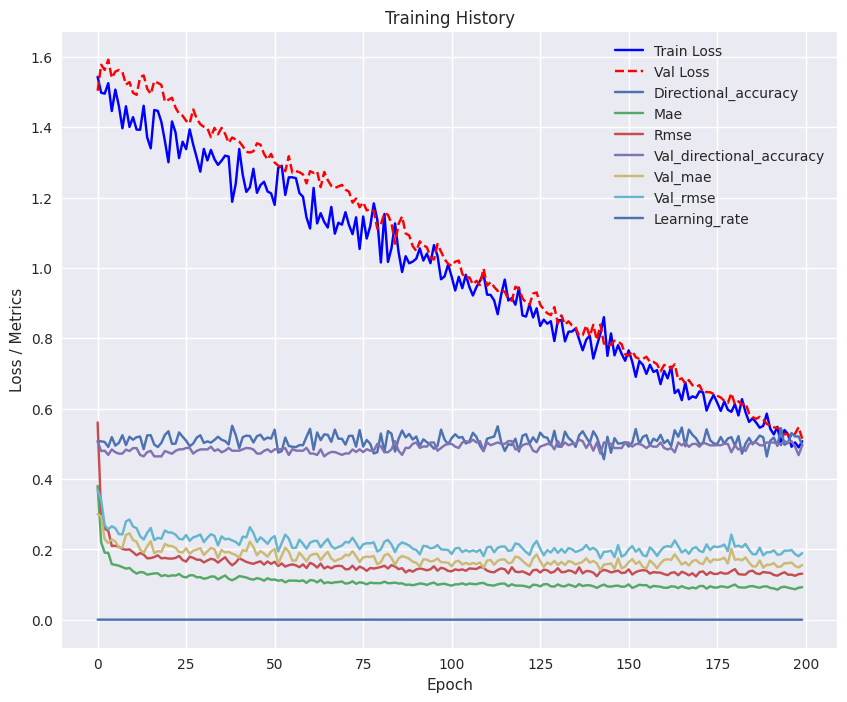

In [ ]:
# Load Training History
results_dir = config.get_path('results_dir')

history_file = os.path.join(results_dir, "ethereum_results_20241210_185204.json")

if os.path.exists(history_file):
    with open(history_file, 'r') as f:
        result_data = json.load(f)
    history = result_data['history']
    viz.plot_training_history(history)
else:
    print("No training history file found, skipping plot.")


## Summary of the Training History:

The plot shows the evolution of various training and validation metrics over the course of 200 training epochs for the predictive model.

1. **Training Loss (Blue line):**  
   - The training loss steadily declines as epochs increase, indicating that the model is successfully learning patterns from the training data.
   - This continuous decrease suggests that the model’s parameters are being effectively updated to reduce prediction errors.

2. **Validation Loss (Red dashed line):**  
   - The validation loss follows a similar downward trend, though it may be slightly more fluctuating than training loss.
   - The gradual decline in validation loss implies that the model is generalizing reasonably well to unseen data.  
   - The close convergence between training and validation losses, especially in later epochs, suggests the model is not overfitting severely.

3. **Other Metrics (Directional Accuracy, MAE, RMSE, and their Validation Counterparts):**  
   - Directional accuracy lines hover roughly around a neutral level, indicating the model’s ability to correctly forecast upward vs. downward direction may not drastically improve over time.
   - MAE and RMSE both show a marked drop in the initial epochs and then hover at relatively stable lower values. This implies the magnitude of the model’s prediction errors reduces quickly early in training and then stabilizes.
   - Validation directional accuracy and validation MAE/RMSE follow patterns similar to their training counterparts, showing initial improvements and eventual stabilization, reinforcing the notion of a balanced training process.

4. **Learning Rate (Very bottom, stable line):**  
   - The learning rate appears to have decreased at predefined intervals (or remained relatively low after initial adjustments), indicating the use of learning rate scheduling techniques.
   - A stabilized low learning rate later in training allows for fine-tuning of the model’s parameters and helps in converging to a lower loss.

**Overall Interpretation:**
- The decreasing training and validation losses reflect effective learning and decent generalization.
- The stable performance metrics (MAE, RMSE) after initial improvements suggest the model reaches a plateau in prediction accuracy.
- While directional accuracy may remain modest, the model’s error magnitude decreases substantially.
- The model does not appear to be overfitting dramatically, as training and validation metrics do not diverge significantly.

In summary, the training history indicates that the model learns meaningful relationships from the data, achieves reasonable accuracy levels, and generalizes fairly well to unseen data by the end of training.

### Evaluate the Model on Test Data

Let's load our trained model and evaluate it on the test set.


2024-12-10 20:31:25,885 - src.training.model - INFO - CryptoPredictor init: LSTM units=[64], Dense units=[32], Dropout=0.2, LR=0.001, Clip Norm=None
CryptoPredictor init: LSTM units=[64], Dense units=[32], Dropout=0.2, LR=0.001, Clip Norm=None
Loaded model from models/ethereum/model.keras
2024-12-10 20:31:25,887 - src.training.model - INFO - Evaluating model...
Evaluating model...
2024-12-10 20:31:29.226401: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-12-10 20:31:31,239 - src.training.model - INFO - Evaluation results: {'loss': 1.60612154006958, 'mae': 0.1639351099729538, 'rmse': 0.1975701004266739, 'directional_accuracy': 0.47159090638160706}
Evaluation results: {'loss': 1.60612154006958, 'mae': 0.1639351099729538, 'rmse': 0.1975701004266739, 'directional_accuracy': 0.47159090638160706}
2024-12-10 20:31:31,242 - src.training.model - INFO - Generating predictions...
Generating predictions...


Evaluation Results (Loss, MAE, RMSE, Directional Accuracy): {'loss': 1.60612154006958, 'mae': 0.1639351099729538, 'rmse': 0.1975701004266739, 'directional_accuracy': 0.47159090638160706}


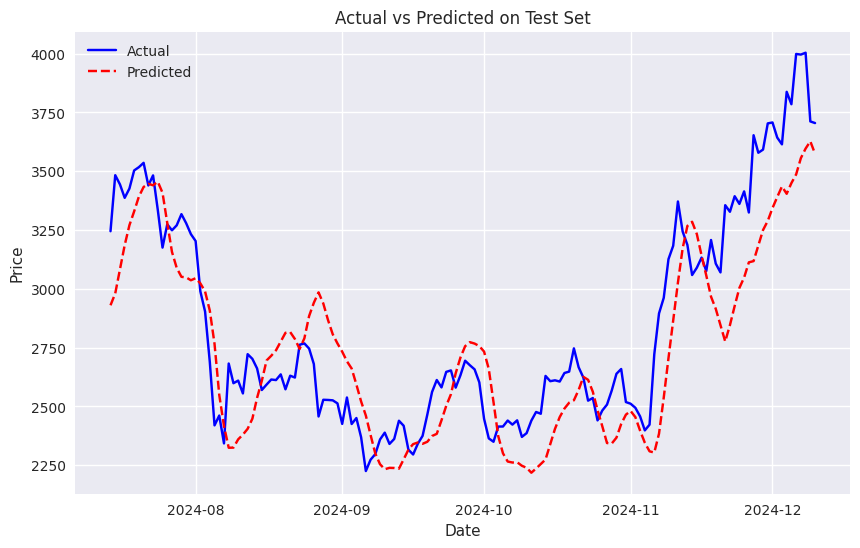

In [4]:
# Evaluate on Test Data
model_path = os.path.join(config.get_path('models_dir'), "ethereum", "model.keras")
model = CryptoPredictor.load(model_path)

eval_results = model.evaluate(X_test, y_test)
print("Evaluation Results (Loss, MAE, RMSE, Directional Accuracy):", eval_results)

# Predictions vs Actual on test set
preds_scaled = model.predict(X_test)
preds_original = pipeline.inverse_transform_predictions(preds_scaled)
y_test_original = pipeline.inverse_transform_actuals(y_test)

# Align predictions with test timestamps
test_len = len(y_test_original)
test_dates = df.index[-test_len:]
actual_series = pd.Series(y_test_original, index=test_dates)
predicted_series = pd.Series(preds_original, index=test_dates)

viz.plot_actual_vs_predicted(actual_series, predicted_series, title="Actual vs Predicted on Test Set")


## **Key Observations:**

1. **Overall Trend Capture:**  
   The predicted series follows the general upward or downward movements observed in the actual prices. This indicates that the model has learned some of the underlying trend.

2. **Underestimation of Volatility:**  
   Although the model aligns somewhat with the larger price swings, it tends to produce a smoother line, showing less volatility than the real market prices. In other words, it often underestimates the magnitude of sudden spikes or drops.

3. **Lagging or Delayed Reactions:**  
   At times, the model appears to react to changes in trend with a slight delay. For example, when the actual price rallies sharply, the predicted line follows the movement but often arrives at those price levels more gradually and with less intensity.

4. **Potential for Improvement:**  
   The discrepancies between actual and predicted lines—particularly around sharp turning points and periods of high volatility—suggest that while the model is on the right track, there’s room for refinement. More complex feature engineering, advanced model architectures, or additional data sources could help the model better capture sudden market moves.

Overall, the plot shows that the model can approximate the general direction of future prices but struggles with rapid price shifts and extremes, highlighting areas for potential future enhancements.

## Future Predictions

Let's now load recent data from `data/raw/predict/ethereum_binance_recent_20241210.csv` and predict the next 5 days.

We will also visualize the predictions.



2024-12-10 20:31:36,356 - src.preprocessing.pipeline - INFO - Applying feature engineering...
Applying feature engineering...
2024-12-10 20:31:36,377 - src.preprocessing.feature_engineering - WARNING - Missing values detected, applying bfill and ffill.
Missing values detected, applying bfill and ffill.
2024-12-10 20:31:36,382 - src.preprocessing.feature_engineering - INFO - All features updated, total columns: 12
All features updated, total columns: 12
2024-12-10 20:31:36,384 - src.preprocessing.feature_engineering - INFO - Added 7 technical features.
Added 7 technical features.
2024-12-10 20:31:36,389 - src.preprocessing.pipeline - INFO - Numeric features identified (excluding close): ['open', 'high', 'low', 'volume', 'rsi', 'macd', 'macd_signal', 'macd_hist', 'bb_upper', 'bb_middle', 'bb_lower']
Numeric features identified (excluding close): ['open', 'high', 'low', 'volume', 'rsi', 'macd', 'macd_signal', 'macd_hist', 'bb_upper', 'bb_middle', 'bb_lower']
2024-12-10 20:31:36,403 - src.

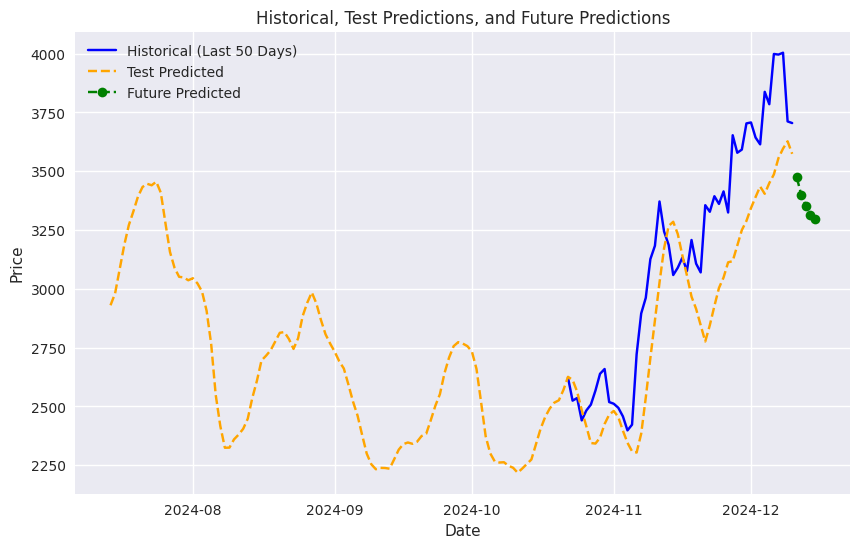

In [5]:
# Future Predictions
predict_data_path = os.path.join(config.get_path('raw_predict_dir'), "ethereum_binance_recent_20241210.csv")
predict_df = pd.read_csv(predict_data_path, index_col=0, parse_dates=True)

prediction_data = pipeline.run(predict_df, prediction_mode=True)
X_recent = prediction_data['X']

future_days = 5
predictions = []
current_X = X_recent.copy()

close_idx = len(pipeline.numeric_features)

for i in range(future_days):
    preds_scaled = model.predict(current_X)
    preds_original = pipeline.inverse_transform_predictions(preds_scaled)
    predicted_price = float(preds_original[0])
    predictions.append(predicted_price)

    # Re-scale and update sequence
    rescaled_close = pipeline.target_scaler.transform(np.array([[predicted_price]]))[0,0]
    new_row = current_X[0, -1, :].copy()
    new_row[close_idx] = rescaled_close
    current_X = np.roll(current_X, -1, axis=1)
    current_X[0, -1, :] = new_row

test_actual_series = actual_series
test_predicted_series = predicted_series


# Now plot all three: historical, test predictions, and future predictions
viz.plot_future_predictions(
    df=df,
    future_predictions=predictions,
    future_days=future_days,
    title="Historical, Test Predictions, and Future Predictions",
    test_predicted=test_predicted_series
)



## Discussion

### Problem Solved
We aimed to forecast the future closing prices of Ethereum for 5 days ahead, providing insights that traders/investors might use as a reference.

### ML Approach
We used an LSTM-based deep learning model to capture temporal dependencies in historical price data. We engineered features (RSI, MACD, Bollinger Bands) to give the model richer information.

### Results and Findings
- The test set evaluation shows how close predictions align with actual prices.
- While predictions are not perfect (financial time series are notoriously unpredictable), we have a baseline model that shows some capability to follow market trends.
- Our EDA highlighted correlations, distributions, and volatility aspects.

### Limitations
- We only used historical price and volume data (plus technical indicators derived from them).
- We didn't include external factors (news, sentiment, macroeconomics).
- Additional data and more model tuning might improve performance.

### Next Steps
- Experiment with different model architectures (GRU, Transformer-based).
- Integrate external data sources.
- Explore feature selection and dimensionality reduction techniques.
- Evaluate against simpler benchmarks (like a naive forecast) to assess added value.

## Conclusion
This project demonstrates a full pipeline: from EDA and feature engineering to model training, evaluation, and forecasting. Though not a crystal ball, the model can potentially aid decision-making by identifying patterns and trends in the market.

---
